In [3]:
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.spatial import Voronoi, cKDTree

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import display, Image

import time

import pandas as pd
import itertools

In [4]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"]})

# Circular grain

In [ ]:
# === Simulation Parameters ===
N = 64
dx = dy = 0.5
L = N * dx
dt = 0.005
nsteps = 5000
snapshot_interval = 500

M = 5.0        # Mobility
kappa = 0.1    # Gradient coefficient
A, B = 1.0, 1.0  # Free energy parameters

# === Wavenumber grids ===
kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(N, d=dy) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2

In [ ]:
# === Free energy derivative ===
def dfdeta(etas, eta_i):
    sum_eta_sq = np.sum(etas**2, axis=0) - eta_i**2
    return A * (2.0 * B * eta_i * sum_eta_sq + eta_i**3 - eta_i)

In [ ]:
# === Circular Two-Grain Initialization ===
def init_circular_two_grains(Nx, Ny):
    ngrain = 2
    etas = np.zeros((ngrain, Nx, Ny))
    glist = np.ones(ngrain, dtype=bool)

    x0, y0 = Nx / 2, Ny / 2
    radius = 14.0

    for i in range(Nx):
        for j in range(Ny):
            dist = np.sqrt((i - x0) ** 2 + (j - y0) ** 2)
            if dist <= radius:
                etas[1, i, j] = 1.0  # Circular grain
            else:
                etas[0, i, j] = 1.0  # Matrix

    return etas, ngrain, glist

In [ ]:
# === Initialize microstructure ===
etas, ngrains, glist = init_circular_two_grains(N, N)

# === Storage for GIF snapshots ===
snapshots = []

# === Time-stepping loop ===
start_time = time.time()
for step in range(1, nsteps + 1):
    for ig in range(ngrains):
        if not glist[ig]:
            continue
        eta = etas[ig]
        dfdeta_real = dfdeta(etas, eta)
        dfdeta_hat = fft2(dfdeta_real)

        # Semi-implicit spectral update
        eta_hat = fft2(eta)
        eta_hat = (eta_hat - dt * M * dfdeta_hat) / (1 + dt * M * kappa * K2)
        eta = np.clip(ifft2(eta_hat).real, 0.00001, 0.9999)
        etas[ig] = eta

        # Grain elimination based on mean over grid
        grain_sum = np.sum(eta) / (N * N)
        if grain_sum <= 0.001:
            glist[ig] = False
            etas[ig] = 0.0  # Clear eliminated grain
            print(f"Grain {ig + 1} eliminated at step {step}")

    # Store snapshot for animation
    if step % snapshot_interval == 0:
        eta2 = np.sum(etas**2, axis=0)  # combined grain structure
        snapshots.append((step * dt, eta2.copy()))
        print(f"Stored snapshot at step {step}")

total_time = time.time() - start_time
print(f"Total compute time: {total_time:.2f} seconds")

In [ ]:
# === Create GIF Animation ===
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(snapshots[0][1], cmap='bwr', vmin=0.0, vmax=1.0)
cb = fig.colorbar(im, ax=ax, label=r'$\sum \eta_i^2$', shrink=0.8)
tx = ax.text(N * 0.7, N * 0.05, f't={snapshots[0][0]:.3f}',
             bbox=dict(boxstyle="round", ec='white', fc='white'))
ax.set_title('Circular Two-Grain Microstructure')

def animate(i):
    t, eta_frame = snapshots[i]
    im.set_data(eta_frame)
    tx.set_text(f't={t:.3f}')
    return im, tx

ani = animation.FuncAnimation(fig, animate, frames=len(snapshots),
                              interval=50, blit=False)

ani.save('circular_two_grain.gif', writer='pillow',fps=20,dpi=150)

In [ ]:
# Display the GIF
display(Image(filename="circular_two_grain.gif"))

# Voronoi mictrostructure

In [5]:
# === Simulation Parameters ===
N = 64
dx = dy = 0.5
L = N * dx
dt = 0.005
nsteps = 20000
snapshot_interval = 100

M = 5.0        # Mobility
kappa = 0.2    # Gradient coefficient
A, B = 1.0, 1.0  # Free energy parameters

# === Wavenumber grids ===
kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
ky = np.fft.fftfreq(N, d=dy) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky, indexing='ij')
K2 = KX**2 + KY**2

In [6]:
# === Free energy derivative ===
def dfdeta(etas, eta_i):
    sum_eta_sq = np.sum(etas**2, axis=0) - eta_i**2
    return A * (2.0 * B * eta_i * sum_eta_sq + eta_i**3 - eta_i)

In [7]:
def procedural_voronoi_microstructure(Nx, Ny, ngrains):
    """
    Procedurally generates a Voronoi-based grain structure with 
    irregular shapes, spatially connected grains, and polygonal regions.
    """
    np.random.seed(1234)
    # Random seed points (grain centers)
    points = np.random.rand(ngrains, 2) * [Nx, Ny]
    
    # Create Voronoi diagram (we won't use its polygons directly but KDTree for speed)
    vor = Voronoi(points)

    # Create the grid of (x, y) positions
    x = np.arange(Nx) + 0.5  # center of pixels
    y = np.arange(Ny) + 0.5
    X, Y = np.meshgrid(x, y, indexing='ij')
    grid_points = np.stack((X.ravel(), Y.ravel()), axis=-1)

    # Use KDTree to assign each grid point to the closest Voronoi seed
    tree = cKDTree(points)
    _, region_ids = tree.query(grid_points)
    grain_map = region_ids.reshape(Nx, Ny)

    # Build etas
    etas = np.zeros((ngrains, Nx, Ny))
    glist = np.ones(ngrains, dtype=bool)
    for i in range(ngrains):
        etas[i, :, :] = (grain_map == i).astype(float)

    return etas, ngrains, glist, grain_map


# === Grain Initialization ===
ngrains = 25  # Example number of grains for Voronoi
etas, ngrains, glist, grain_map = procedural_voronoi_microstructure(N, N, ngrains)


# === Sanity checks ===
#unique_grains = np.unique(grain_map)
#print(f"Number of unique grains: {len(unique_grains)}")

#plt.figure(figsize=(5, 5))
#cmap = plt.get_cmap('tab20', ngrains)  # Up to 20 unique colors cycling
#plt.imshow(grain_map, cmap=cmap)
#plt.colorbar(ticks=np.arange(0, ngrains, max(1, ngrains // 10)))
#plt.tight_layout()
#plt.show()

Grain 8 eliminated at step 795


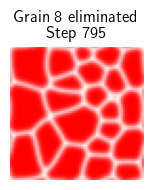

Grain 15 eliminated at step 840


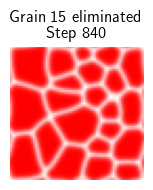

Grain 14 eliminated at step 995


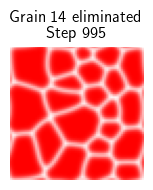

Grain 24 eliminated at step 2884


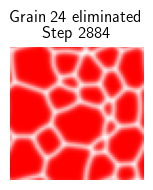

Grain 7 eliminated at step 3530


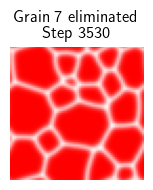

Grain 2 eliminated at step 3593


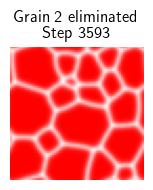

Grain 18 eliminated at step 3594


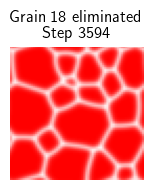

Grain 25 eliminated at step 4131


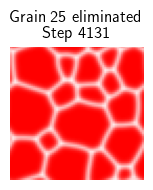

Grain 5 eliminated at step 5559


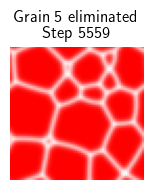

Grain 12 eliminated at step 5768


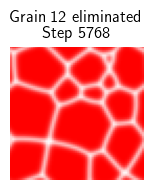

Grain 3 eliminated at step 5822


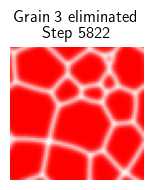

Grain 22 eliminated at step 6047


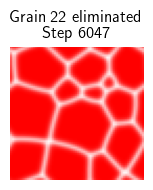

Grain 4 eliminated at step 6798


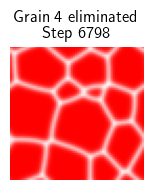

Grain 11 eliminated at step 7522


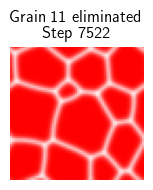

Grain 6 eliminated at step 9007


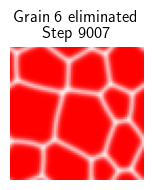

Grain 13 eliminated at step 14461


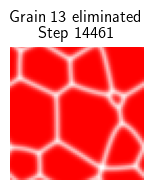

Grain 20 eliminated at step 15032


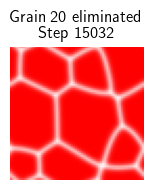

Total compute time: 95.39 seconds


In [8]:
# === Storage for GIF snapshots and Pandas area tracking ===
snapshots = []
area_fraction_records = []

# === Helper: Inline plot microstructure ===
def show_microstructure(etas, step, event=""):
    eta2 = np.sum(etas**2, axis=0)
    plt.figure(figsize=(2, 2))
    plt.imshow(eta2, cmap='bwr', vmin=0.0, vmax=1.0)
    plt.title(f'{event}\nStep {step}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# === Time-stepping loop ===
start_time = time.time()

# Plot initial structure at t = 0
#show_microstructure(etas, step=0, event="Initial")

for step in range(1, nsteps + 1):
    for ig in range(ngrains):
        if not glist[ig]:
            continue
        eta = etas[ig]
        dfdeta_real = dfdeta(etas, eta)
        dfdeta_hat = fft2(dfdeta_real)

        # Semi-implicit spectral update
        eta_hat = fft2(eta)
        eta_hat = (eta_hat - dt * M * dfdeta_hat) / (1 + dt * M * kappa * K2)
        eta = np.clip(ifft2(eta_hat).real, 0.00001, 0.9999)
        etas[ig] = eta

        # Grain elimination check
        grain_sum = np.sum(eta) / (N * N)
        if grain_sum <= 0.001:
            glist[ig] = False
            etas[ig] = 0.0
     #       print(f"Grain {ig + 1} eliminated at step {step}")
            show_microstructure(etas, step=step, event=f"Grain {ig+1} eliminated")

    # Optional: Store snapshots for animation
    if step % snapshot_interval == 0:
        eta2 = np.sum(etas**2, axis=0)
        snapshots.append((step * dt, eta2.copy()))

    # === Store area fractions in Pandas structure ===
    if step % snapshot_interval == 0 or step == 1:
        fractions = [np.sum(etas[ig]) / (N * N) if glist[ig] else 0.0 for ig in range(ngrains)]
        record = {'time': step * dt}
        for ig in range(ngrains):
            record[f'grain_{ig+1}'] = fractions[ig]
        area_fraction_records.append(record)

total_time = time.time() - start_time
print(f"Total compute time: {total_time:.2f} seconds")

In [9]:
# Convert to Pandas DataFrame
area_df = pd.DataFrame(area_fraction_records)
area_df.set_index('time', inplace=True)

# Optional: save the CSV
# area_df.to_csv('grain_area_fractions.csv')

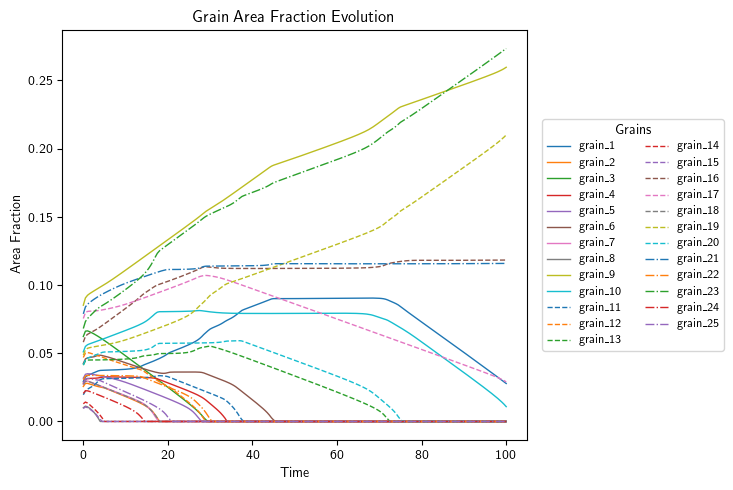

In [10]:
# Prepare color and linestyle cycling
color_cycle = plt.cm.tab10.colors  # 20 distinct colors
linestyles = ['-', '--', '-.', ':']
style_cycler = itertools.cycle([(color, ls) for ls in linestyles for color in color_cycle])

plt.figure(figsize=(10, 5))

for i, col in enumerate(area_df.columns):
    color, ls = next(style_cycler)
    plt.plot(area_df.index, area_df[col], label=col, color=color, linestyle=ls, linewidth=1)

plt.xlabel('Time')
plt.ylabel('Area Fraction')
plt.title('Grain Area Fraction Evolution')

# Legend outside the plot, 2 columns
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
           ncol=2, fontsize='small', title='Grains')
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Leave space on the right for legend
plt.show()

In [ ]:
# === Create GIF Animation ===
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(snapshots[0][1], cmap='bwr', vmin=0.0, vmax=1.0)
cb = fig.colorbar(im, ax=ax, label=r'$\sum \eta_i^2$', shrink=0.8)
tx = ax.text(N * 0.7, N * 0.05, f't={snapshots[0][0]:.3f}',
             bbox=dict(boxstyle="round", ec='white', fc='white'))
ax.set_title('Ostwald ripening\nin Voronoi microstructure')

def animate(i):
    t, eta_frame = snapshots[i]
    im.set_data(eta_frame)
    tx.set_text(f't={t:.3f}')
    return im, tx

ani = animation.FuncAnimation(fig, animate, frames=len(snapshots),
                              interval=50, blit=False)

ani.save('voronoi.gif', writer='pillow',fps=20,dpi=150)

In [ ]:
# Replace 'path_to_your_gif.gif' with the actual path to your GIF file
#gif_path = 'path_to_your_gif.gif'

# Display the GIF
display(Image(filename="voronoi.gif"))